In [1]:
# ================================
# Mumbai Traffic Congestion Forecasting (XGBoost)
# Multi-horizon (+1h, +2h, +6h, +24h)
# FULL CORRECTED CODE (training + saving models + saving one-hot schema + inference)
# ================================

import os
import json
import joblib
import numpy as np
import pandas as pd

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -------------------------
# CONFIG
# -------------------------
DATA_PATH = "mumbai_synthetic_congestion_dataset_2y.csv"  # <- your dataset path
MODELS_DIR = "models"
os.makedirs(MODELS_DIR, exist_ok=True)

LAGS = [1, 2, 3, 6, 24]
HORIZONS = [1, 2, 6, 24]

# If you want road-specific learning, include road_id as a categorical feature (recommended)
USE_ROAD_ID_AS_FEATURE = True

# -------------------------
# 1) LOAD + SORT
# -------------------------
df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"])
df = df.sort_values(["road_id", "timestamp"]).reset_index(drop=True)

# -------------------------
# 2) FEATURE ENGINEERING (LAGS)
# -------------------------
for lag in LAGS:
    df[f"congestion_lag_{lag}"] = df.groupby("road_id")["congestion_level"].shift(lag)

# Use avg_speed_kph and delay_ratio from dataset
df["speed_lag_1"] = df.groupby("road_id")["avg_speed_kph"].shift(1)
df["delay_lag_1"] = df.groupby("road_id")["delay_ratio"].shift(1)

# -------------------------
# 3) TARGETS (FUTURE HORIZONS)
# -------------------------
for h in HORIZONS:
    df[f"target_congestion_t_plus_{h}h"] = df.groupby("road_id")["congestion_level"].shift(-h)

# -------------------------
# 4) SELECT FEATURES / TARGETS
# -------------------------
FEATURES = [
    # Traffic memory
    "congestion_lag_1", "congestion_lag_2", "congestion_lag_3",
    "congestion_lag_6", "congestion_lag_24",
    "speed_lag_1", "delay_lag_1",

    # Time
    "hour", "day_of_week", "is_weekend", "month",

    # Road identity
    "road_class",

    # Risk priors
    "accident_hotspot_score",
    "recent_incident_count",
    "enforcement_violation_pattern",
    "long_term_risk_prior",
]

TARGETS = [f"target_congestion_t_plus_{h}h" for h in HORIZONS]

# Keep only needed cols
keep_cols = ["timestamp", "road_id"] + FEATURES + TARGETS
model_df = df[keep_cols].dropna().copy()

# Sort strictly by time for time-based split (prevents leakage)
model_df = model_df.sort_values("timestamp").reset_index(drop=True)

# -------------------------
# 5) ONE-HOT ENCODING (SAVE SCHEMA)
# -------------------------
cat_cols = ["road_class"] + (["road_id"] if USE_ROAD_ID_AS_FEATURE else [])

# One-hot encode on the FULL model_df to create the stable schema
encoded_df = pd.get_dummies(model_df, columns=cat_cols, drop_first=False)

# Features after encoding: all columns except timestamp and targets
encoded_feature_cols = [c for c in encoded_df.columns if c not in (["timestamp"] + TARGETS)]

# Save one-hot schema (this is what you load at inference)
schema = {
    "cat_cols": cat_cols,
    "feature_cols": encoded_feature_cols,
    "features_before_encoding": FEATURES,
    "use_road_id_as_feature": USE_ROAD_ID_AS_FEATURE,
    "lags": LAGS,
    "horizons": HORIZONS
}
joblib.dump(schema, os.path.join(MODELS_DIR, "onehot_schema.pkl"))

# -------------------------
# 6) TRAIN/VAL/TEST SPLIT (TIME-BASED)
# -------------------------
split_train = int(len(encoded_df) * 0.70)
split_val   = int(len(encoded_df) * 0.85)

train_df = encoded_df.iloc[:split_train].copy()
val_df   = encoded_df.iloc[split_train:split_val].copy()
test_df  = encoded_df.iloc[split_val:].copy()

X_train = train_df[encoded_feature_cols]
X_val   = val_df[encoded_feature_cols]
X_test  = test_df[encoded_feature_cols]

# -------------------------
# 7) TRAIN MODELS (ONE PER HORIZON) + SAVE
# -------------------------
models = {}
results = []

for h in HORIZONS:
    target = f"target_congestion_t_plus_{h}h"

    y_train = train_df[target]
    y_val   = val_df[target]
    y_test  = test_df[target]

    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_lambda=1.0,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1,
    )

    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    preds = model.predict(X_test)
    mae = mean_absolute_error(y_test, preds)
    rmse = np.sqrt(mean_squared_error(y_test, preds))

    results.append((h, mae, rmse))
    print(f"Horizon +{h}h -> MAE={mae:.6f}, RMSE={rmse:.6f}")

    model_path = os.path.join(MODELS_DIR, f"xgb_congestion_plus_{h}h.pkl")
    joblib.dump(model, model_path)

    models[h] = model

results_df = pd.DataFrame(results, columns=["horizon_hours", "MAE", "RMSE"])
print("\nFinal Results:\n", results_df)

# Save results table
results_df.to_csv(os.path.join(MODELS_DIR, "results.csv"), index=False)

# -------------------------
# 8) INFERENCE HELPERS (USER PROVIDES road_id)
# -------------------------
def _prepare_onehot_row(raw_row_df: pd.DataFrame, schema_path: str = os.path.join(MODELS_DIR, "onehot_schema.pkl")) -> pd.DataFrame:
    """
    raw_row_df: a DataFrame with columns needed for FEATURES + (road_id if enabled)
    Returns: one-hot encoded DataFrame with EXACT training columns (schema.feature_cols)
    """
    schema = joblib.load(schema_path)
    cat_cols = schema["cat_cols"]
    feature_cols = schema["feature_cols"]

    enc = pd.get_dummies(raw_row_df, columns=cat_cols, drop_first=False)
    enc = enc.reindex(columns=feature_cols, fill_value=0)

    return enc


def build_features_for_road_at_time(
    full_df: pd.DataFrame,
    road_id: str,
    ts: pd.Timestamp
) -> pd.DataFrame:
    """
    Builds a SINGLE feature row for one road at the given timestamp ts.
    Requirements:
      - full_df must include all original dataset columns (before encoding)
      - full_df must be sorted by ["road_id","timestamp"]
      - ts must exist for that road (we use the latest row <= ts)
    """
    road_hist = full_df[full_df["road_id"] == road_id].sort_values("timestamp")
    if road_hist.empty:
        raise ValueError(f"road_id={road_id} not found in dataset")

    # choose the last available row at or before ts
    road_hist = road_hist[road_hist["timestamp"] <= ts]
    if road_hist.empty:
        raise ValueError(f"No data for road_id={road_id} at/before timestamp={ts}")

    row = road_hist.iloc[-1].copy()

    # Ensure lag features are present for that row in original df (they were created above in df)
    # If user passes full_df=df from the notebook, those lag columns exist.
    needed = FEATURES.copy()
    if USE_ROAD_ID_AS_FEATURE:
        needed = ["road_id"] + needed

    missing = [c for c in needed if c not in full_df.columns and c not in row.index]
    if missing:
        raise ValueError(f"Missing required feature columns: {missing}")

    # Build 1-row DataFrame
    feat_dict = {c: row[c] for c in FEATURES}
    if USE_ROAD_ID_AS_FEATURE:
        feat_dict["road_id"] = road_id

    raw_row_df = pd.DataFrame([feat_dict])
    return raw_row_df


def load_models(models_dir: str = MODELS_DIR):
    """
    Loads saved horizon models.
    """
    loaded = {}
    for h in HORIZONS:
        loaded[h] = joblib.load(os.path.join(models_dir, f"xgb_congestion_plus_{h}h.pkl"))
    return loaded


def predict_all_horizons(
    full_df_with_lags: pd.DataFrame,
    road_id: str,
    ts: pd.Timestamp
) -> dict:
    """
    Returns predictions for +1h, +2h, +6h, +24h for given road_id at time ts.
    """
    schema_path = os.path.join(MODELS_DIR, "onehot_schema.pkl")
    models = load_models(MODELS_DIR)

    raw_row = build_features_for_road_at_time(full_df_with_lags, road_id, ts)
    X = _prepare_onehot_row(raw_row, schema_path=schema_path)

    out = {"road_id": road_id, "timestamp": str(ts)}
    for h, m in models.items():
        out[f"pred_congestion_plus_{h}h"] = float(m.predict(X)[0])

    return out


# -------------------------


Horizon +1h -> MAE=0.056416, RMSE=0.072809
Horizon +2h -> MAE=0.059672, RMSE=0.076716
Horizon +6h -> MAE=0.065779, RMSE=0.083899
Horizon +24h -> MAE=0.067390, RMSE=0.085835

Final Results:
    horizon_hours       MAE      RMSE
0              1  0.056416  0.072809
1              2  0.059672  0.076716
2              6  0.065779  0.083899
3             24  0.067390  0.085835


In [5]:

 example_road = df["road_id"].iloc[0]
 example_time = df["timestamp"].max()
 preds = predict_all_horizons(df, example_road, example_time)
 print("\nExample prediction:\n", json.dumps(preds, indent=2))   


Example prediction:
 {
  "road_id": "AIR_1",
  "timestamp": "2026-02-07 17:30:00+05:30",
  "pred_congestion_plus_1h": 0.3529244363307953,
  "pred_congestion_plus_2h": 0.380637526512146,
  "pred_congestion_plus_6h": 0.40358296036720276,
  "pred_congestion_plus_24h": 0.39942666888237
}


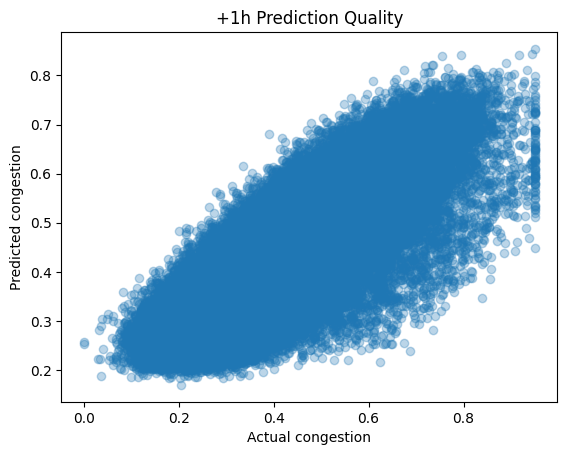

In [6]:
import matplotlib.pyplot as plt

h = 1  # example
y_true = test_df[f"target_congestion_t_plus_{h}h"]
y_pred = models[h].predict(X_test)

plt.figure()
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xlabel("Actual congestion")
plt.ylabel("Predicted congestion")
plt.title(f"+{h}h Prediction Quality")
plt.show()


In [11]:
importances = models[1].feature_importances_
imp_df = pd.DataFrame({
    "feature": X_train.columns,
    "importance": importances
}).sort_values("importance", ascending=False)

print(imp_df.head(15))


                          feature  importance
6                     delay_lag_1    0.519304
0                congestion_lag_1    0.078074
1                congestion_lag_2    0.047076
12          recent_incident_count    0.030640
4               congestion_lag_24    0.017905
2                congestion_lag_3    0.014283
34                  road_id_EEH_2    0.007689
16             road_class_highway    0.007565
14           long_term_risk_prior    0.007140
75                  road_id_SVR_3    0.007000
13  enforcement_violation_pattern    0.006525
36                  road_id_EEH_4    0.006417
11         accident_hotspot_score    0.006387
3                congestion_lag_6    0.006329
89                  road_id_WEH_7    0.005891


In [12]:
import matplotlib.pyplot as plt

IMP_DIR = os.path.join(MODELS_DIR, "feature_importance")
os.makedirs(IMP_DIR, exist_ok=True)

for h in HORIZONS:
    model = models[h]
    importances = model.feature_importances_

    imp_df = pd.DataFrame({
        "feature": X_train.columns,
        "importance": importances
    }).sort_values("importance", ascending=False).head(20)

    plt.figure(figsize=(8, 6))
    plt.barh(imp_df["feature"], imp_df["importance"])
    plt.gca().invert_yaxis()
    plt.title(f"Top Features (+{h}h)")
    plt.tight_layout()
    plt.savefig(os.path.join(IMP_DIR, f"feature_importance_plus_{h}h.png"))
    plt.close()


In [13]:
baseline_info = {
    "version": "v1",
    "model": "XGBoost mean regression",
    "horizons": HORIZONS,
    "loss": "RMSE",
    "notes": "Baseline multi-horizon congestion forecasting model"
}

with open(os.path.join(MODELS_DIR, "baseline_v1.json"), "w") as f:
    json.dump(baseline_info, f, indent=2)


In [14]:
def congestion_alert_logic(preds: dict, raw_row: pd.DataFrame) -> str:
    """
    preds: output from predict_all_horizons
    raw_row: raw feature row (before one-hot)
    """
    p1 = preds["pred_congestion_plus_1h"]
    p2 = preds["pred_congestion_plus_2h"]
    incidents = raw_row["recent_incident_count"].iloc[0]

    if p1 > 0.7:
        return "🚨 SEVERE congestion expected within 1 hour"
    if p1 > 0.6 or p2 > 0.7:
        return "⚠️ High congestion risk ahead"
    if incidents >= 2:
        return "⚠️ Incident-driven congestion possible"
    return "✅ Traffic conditions expected to remain stable"


In [15]:
def predict_with_alert(full_df, road_id, ts):
    raw_row = build_features_for_road_at_time(full_df, road_id, ts)
    preds = predict_all_horizons(full_df, road_id, ts)
    alert = congestion_alert_logic(preds, raw_row)

    preds["alert"] = alert
    return preds
